In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import warnings
from utils.data_preprocessing import *
from utils.metrics import *
from utils.visualization import *
from models.model import *
from models.optimizer import *
warnings.filterwarnings('ignore')
%matplotlib inline

# 1. Data Preprocessing

## 1.1. Data Exploration

In [11]:
df = pd.read_csv("Data/Final_train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1647 entries, 0 to 1646
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Year                            1647 non-null   int64  
 1   Kilometer                       1647 non-null   float64
 2   Length                          1647 non-null   float64
 3   Width                           1647 non-null   float64
 4   Height                          1647 non-null   float64
 5   Fuel Tank Capacity              1647 non-null   float64
 6   Log_Price                       1647 non-null   float64
 7   Engine_Value                    1647 non-null   float64
 8   Max_Power_Value                 1647 non-null   float64
 9   Max_Power_RPM                   1647 non-null   float64
 10  Max_Torque_Value                1647 non-null   float64
 11  Max_Torque_RPM                  1647 non-null   float64
 12  Make_encoded                    16

## 1.2. Feature Engineering

In [12]:
# Ensure 'Price' column exists (calculated from 'Log_Price' if necessary)
if 'Log_Price' in df.columns and 'Price' not in df.columns:
    df['Price'] = np.exp(df['Log_Price'])
elif 'Price' not in df.columns:
    raise ValueError("DataFrame must contain either 'Price' or 'Log_Price' column.")

# --- Outlier Removal (same as original script) ---
price_threshold = df['Price'].quantile(0.995)
print(f"Ngưỡng giá để xác định outlier: {price_threshold:.2f}")
df_clean = df[df['Price'] <= price_threshold].copy()
print(f"Số dòng đã loại bỏ: {len(df) - len(df_clean)}")
# NOTE: The original script calculates df_clean but then proceeds with df.
# We will follow the original script's logic and continue using df.
# If df_clean was intended, replace df=df below with df_clean=df_clean

# --- Feature Engineering (same as original script) ---
print("Starting Feature Engineering...")
# (Copying the FE block directly)
df['Volume'] = df['Length'] * df['Width'] * df['Height']
# Check for NaNs/Infs before division
df['Power_to_Weight'] = df['Max_Power_Value'] / df['Volume'].replace(0, 1e-6) # Avoid division by zero
df['Efficiency'] = df['Max_Power_Value'] / df['Fuel Tank Capacity'].replace(0, 1e-6)
df['Power_Density'] = df['Max_Power_Value'] / df['Max_Power_RPM'].replace(0, 1e-6)
df['Torque_Density'] = df['Max_Torque_Value'] / df['Max_Torque_RPM'].replace(0, 1e-6)
df['Power_Torque_Ratio'] = df['Max_Power_Value'] / df['Max_Torque_Value'].replace(0, 1e-6)
df['Length_Width_interaction'] = df['Length'] * df['Width']
df['Kilometer_Log'] = np.log(df['Kilometer'] - df['Kilometer'].min() + 1e-3) # Check min value

# Log and Square transformations
log_sq_cols = ['Year', 'Kilometer', 'Length', 'Width', 'Height', 'Fuel Tank Capacity',
               'Engine_Value', 'Max_Power_Value', 'Max_Power_RPM', 'Max_Torque_Value', 'Max_Torque_RPM']
for col in log_sq_cols:
    if col in df.columns:
        # Clip to avoid log(0) or log(negative) after potential subtractions
        clipped_col = df[col].clip(lower=0.001)
        df[f'{col}_log'] = np.log1p(clipped_col) # Use log1p for stability near 0
        df[f'{col}_squared'] = df[col]**2

# Further Feature Engineering
df['Volume'] = df['Length'] * df['Width'] * df['Height']
df['Age'] = 2025 - df['Year']
df['Age'] = df['Age'].clip(lower=0) # Age cannot be negative
df['Age_Volume'] = df['Age'] * df['Volume']
df['Age_Kilometer'] = df['Age'] * df['Kilometer']
df['Kilometer_per_Year'] = df['Kilometer'] / df['Age'].clip(lower=1) # Avoid division by zero or near-zero age

df['Power_to_Weight'] = df['Max_Power_Value'] / df['Volume'].clip(lower=1e-6)
df['Power_to_CC'] = df['Max_Power_Value'] / df['Engine_Value'].clip(lower=1)
df['Torque_to_CC'] = df['Max_Torque_Value'] / df['Engine_Value'].clip(lower=1)
df['Power_to_Torque'] = df['Max_Power_Value'] / df['Max_Torque_Value'].clip(lower=1e-6)
df['RPM_Ratio'] = df['Max_Power_RPM'] / df['Max_Torque_RPM'].clip(lower=1)

df['Efficiency_Index'] = df['Max_Power_Value'] / (df['Engine_Value'] * df['Fuel Tank Capacity']).clip(lower=1)
df['Performance_Index'] = (df['Max_Power_Value'] * df['Max_Torque_Value']) / df['Engine_Value'].clip(lower=1)
df['Luxury_Index'] = df['Volume'] * df['Max_Power_Value'] / 1000
df['Size_Ratio'] = df['Length'] / df['Width'].clip(lower=1)
df['Space_Efficiency'] = df['Volume'] / df['Engine_Value'].clip(lower=1)

df['Power_Polynomial'] = df['Max_Power_Value']**2 / df['Engine_Value'].clip(lower=1)
df['Mileage_Decay'] = np.exp(-df['Kilometer'] / 100000)
# Ensure Make_encoded exists before using it
if 'Make_encoded' in df.columns:
    df['Premium_Power'] = df['Max_Power_Value'] * (df['Make_encoded'] > 5).astype(int)
else:
    print("Warning: 'Make_encoded' column not found. Skipping 'Premium_Power' feature.")
    # Handle cases where expected columns might be missing after FE if source data changes
    df['Premium_Power'] = 0 # Assign a default value

print("Feature Engineering Complete.")


# --- Feature Selection (same as original script) ---
selected_features = [
    'Year', # Chọn cứng feat này
    'Kilometer', # Chọn cứng
    'Length', # Không chắc
    'Fuel Tank Capacity', # Không chắc
    # 'Engine_Value',
    'Max_Power_Value', # Không chắc
    'Max_Power_RPM', # Không chắc
    'Max_Torque_Value', # Không chắc
    # 'Max_Torque_RPM', 
    'Make_encoded', # Chọn cứng

    # Nếu chọn thì chọn tất cả Fuel_%
    'Fuel_CNG',
    'Fuel_Others', 
    'Fuel_Petrol', 


    'Transmission_is_Automatic', # Không chắc


    'Volume', # Không chắc
    # 'Power_to_Weight', # Không chắc
    'Efficiency', # Không chắc
    # 'Power_Density', # Có thể nhưng không nên sài
    # 'Torque_Density', # Có thể nhưng không nên sài
    # 'Power_Torque_Ratio', # Có thể nhưng không nên sài
    # 'Length_Width_interaction', # Có thể nhưng không nên sài
    'Age_Volume', # Không chắc
    'Age_Kilometer', # Không chắc
    'Kilometer_per_Year', # Không chắc
    'Power_to_CC', # Không chắc
    # 'Torque_to_CC', # Có thể nhưng không nên sài
    'Power_to_Torque', # Không chắc
    'RPM_Ratio', # Không chắc

    # Nếu sài thì sài tất cả cột Color_%
    # 'Color_Medium',
    # 'Color_Premium',
    # 'Color_Rare',
    'Color_Silver',
    # 'Color_Standard',

    # Nếu sài thì sài tất cả cột Owner_%
    'Owner_First_Owner',
    'Owner_Fourth_Plus_Owner',
    'Owner_New',
    'Owner_Second_Owner',
    'Owner_Third_Owner',

    # Nếu sài thì sài tất cả cột Seller_%
    # 'Seller_Commercial Registration',
    # 'Seller_Corporate',

    # Phải chọn
    'Seating_2', 'Seating_4', 'Seating_6', 'Seating_7', 'Seating_8'
]

# Ensure 'Make_encoded' is added if it exists
if 'Make_encoded' in df.columns:
    selected_features.append('Make_encoded')
# Ensure 'Premium_Power' is added if it exists and Make_encoded was present
if 'Premium_Power' in df.columns:
     selected_features.append('Premium_Power')


# Filter selected_features to only include columns that actually exist in df
existing_features = [f for f in selected_features if f in df.columns]
print(f"\nUsing {len(existing_features)} existing features.")
# print(f"Features used: {existing_features}") # Uncomment to see the list

# Check if target variable exists
if 'Log_Price' not in df.columns:
    raise ValueError("'Log_Price' column is missing from the DataFrame after processing.")

# Handle potential NaN/inf values created during Feature Engineering
print("\nHandling potential NaN/Inf values...")
X = df[existing_features].copy()
y = df['Log_Price'].copy()

# Replace inf with large number (or NaN), then fill NaNs
X.replace([np.inf, -np.inf], np.nan, inplace=True)
# Simple mean imputation for remaining NaNs - consider more sophisticated methods if needed
if X.isnull().sum().sum() > 0:
    print(f"Warning: Found {X.isnull().sum().sum()} NaN values in features. Imputing with column means.")
    X.fillna(X.mean(), inplace=True)

# Check y for NaNs/Infs as well
if y.isnull().sum() > 0 or np.isinf(y).sum() > 0 :
     print(f"Warning: Found {y.isnull().sum()} NaNs and {np.isinf(y).sum()} Infs in target 'Log_Price'.")
     # Option: Remove rows with bad target values
     valid_indices = y.notnull() & (~np.isinf(y))
     X = X[valid_indices]
     y = y[valid_indices]
     print(f"Removed rows with NaN/Inf in target. New shape: X={X.shape}, y={y.shape}")

# Create X and y
# X = df[existing_features] # Re-select after potential NaN removal
# y = df['Log_Price']

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# --- Train-Test Split using Custom Function ---
print("\nSplitting data using custom train_test_split...")
# Custom function takes train_size, sklearn takes test_size
X_train, y_train, X_test, y_test = train_test_split(X, y, train_size=0.8, random_seed=43)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# --- Feature Scaling using Custom StandardScaler ---
# IMPORTANT: Scale features for gradient-based optimizers
print("\nScaling features using custom StandardScaler...")
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test) # Use transform on test data

# Optional: Scale y? Usually not needed if target is already log-transformed.
# scaler_y = StandardScaler()
# y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten() # Reshape for scaler
# y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

Ngưỡng giá để xác định outlier: 17586000.00
Số dòng đã loại bỏ: 9
Starting Feature Engineering...
Feature Engineering Complete.

Using 33 existing features.

Handling potential NaN/Inf values...
Shape of X: (1647, 33)
Shape of y: (1647,)

Splitting data using custom train_test_split...
X_train shape: (1317, 33), y_train shape: (1317,)
X_test shape: (330, 33), y_test shape: (330,)

Scaling features using custom StandardScaler...


# 2. Model Building & Training


--- 4. Training Linear Regression (NumPy Normal Equation) ---

--- 5. Making Predictions (NumPy) ---
Predictions on log scale completed.
Sample log predictions: [13.29875706 12.81852294 13.93119871 13.70179322 13.99663594]

--- 8. Visualizing Results (Matplotlib) ---


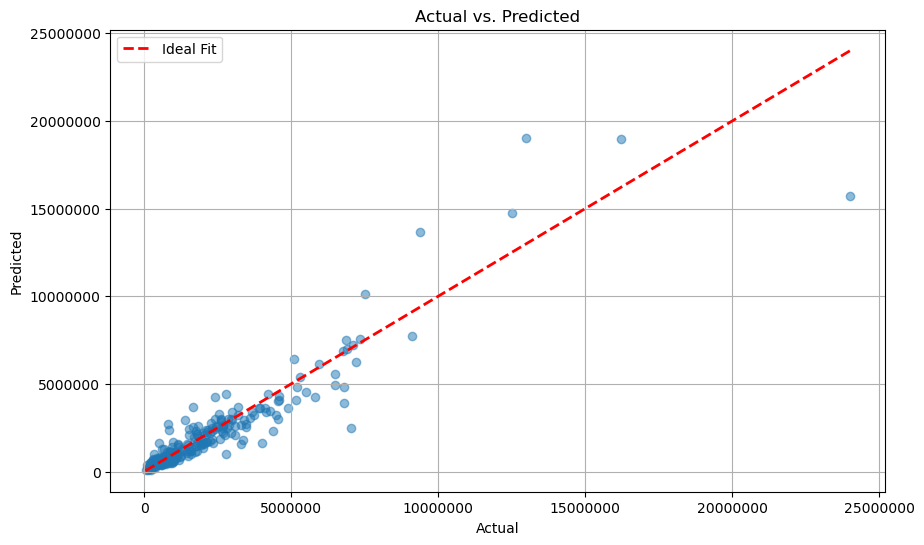

Plot displayed.


In [23]:
# --- 4. Custom Linear Regression (Normal Equation) ---
print("\n--- 4. Training Linear Regression (NumPy Normal Equation) ---")

def numpy_linear_regression_fit(X_train, y_train):
    """Fits Linear Regression using the Normal Equation."""
    # Add intercept term (column of ones)
    X_b = np.c_[np.ones((X_train.shape[0], 1)), X_train] # Add x0 = 1 to each instance

    # Normal Equation: theta = (X_b^T * X_b)^(-1) * X_b^T * y
    try:
        theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_train)
    except np.linalg.LinAlgError:
        print("Warning: Matrix inversion failed. Using pseudo-inverse (Moore-Penrose).")
        # Use pseudo-inverse if matrix is singular (more robust)
        theta = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_train)
    return theta

# Train the model
theta = numpy_linear_regression_fit(X_train, y_train)
intercept = theta[0]
coefficients = theta[1:]

# --- 5. Custom Prediction Function ---
print("\n--- 5. Making Predictions (NumPy) ---")

def numpy_linear_regression_predict(X_test, theta):
    """Makes predictions using the calculated theta."""
    # Add intercept term (column of ones)
    X_b = np.c_[np.ones((X_test.shape[0], 1)), X_test] # Add x0 = 1
    # Prediction: y_pred = X_b * theta
    y_pred = X_b.dot(theta)
    return y_pred

# Make predictions on the test set (log scale)
y_pred_log = numpy_linear_regression_predict(X_test, theta)
print("Predictions on log scale completed.")
print("Sample log predictions:", y_pred_log[:5])

# Inverse transform predictions and actual values to original scale
# y_test_np contains log1p_Price values
y_pred_actual = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test) # Convert original log test target back

# Handle potential negative predictions
y_pred_actual[y_pred_actual < 0] = 0 # Cap predictions at 0

# --- 8. Visualize Predictions (Matplotlib) ---
print("\n--- 8. Visualizing Results (Matplotlib) ---")
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_pred_actual, alpha=0.5)
# Add the ideal fit line (y=x)
min_val = min(y_test_actual.min(), y_pred_actual.min())
max_val = max(y_test_actual.max(), y_pred_actual.max())
plt.plot([min_val, max_val], [min_val, max_val], '--r', linewidth=2, label='Ideal Fit')
plt.xlabel(f"Actual")
plt.ylabel(f"Predicted")
plt.title(f"Actual vs. Predicted")
plt.ticklabel_format(style='plain', axis='both') # Avoid scientific notation
plt.legend()
plt.grid(True)
plt.show()
print("Plot displayed.")

# 3. Model Evaluation

In [14]:
# --- Evaluation using Custom Metrics ---
print("\nEvaluating model performance...")

# Calculate metrics for Log_Price using functions from metrics.py
mse_log = mean_squared_error(y_test_actual, y_pred_actual)
mae_log = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

# Print metrics for Log_Price (Test Set)
print("\nMetrics for Log_Price (Test Set):")
print(f"MSE: {mse_log:.4f}")
print(f"MAE: {mae_log:.4f}")
print(f"R^2: {r2:.4f}")


Evaluating model performance...

Metrics for Log_Price (Test Set):
MSE: 785975436850.9492
MAE: 416116.9684
R^2: 0.8651
